In [1]:
import numpy as np
import math
import pandas as pd
import xarray as xr

import dask

import matplotlib.pyplot as plt

## Dask cluster

In [2]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    account="pches",
    # account="open",
    cores=1,
    memory="4GB",
    walltime="00:20:00",
)

cluster.scale(jobs=10)

In [3]:
# print(cluster.job_script())

In [3]:
from dask.distributed import Client

client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.1.23:36787,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# LOCA-VIC outputs

## Normalization

In [5]:
# Read all
ds_layer1 = xr.open_mfdataset('/storage/group/pches/default/users/dcl5300/LOCA_VIC_soilMoist/Livneh_L14_CONUS/soilMoist1.*.v0.nc')
ds_layer2 = xr.open_mfdataset('/storage/group/pches/default/users/dcl5300/LOCA_VIC_soilMoist/Livneh_L14_CONUS/soilMoist2.*.v0.nc')
ds_layer3 = xr.open_mfdataset('/storage/group/pches/default/users/dcl5300/LOCA_VIC_soilMoist/Livneh_L14_CONUS/soilMoist3.*.v0.nc')

In [6]:
# Merge
ds_all = xr.merge([ds_layer1, ds_layer2, ds_layer3])

# Drop 1950 since it contains outliers
ds_all = ds_all.sel(Time=slice("1951-01-01", "2013-12-31"))

# Sum
ds_all['soilMoist'] = ds_all['soilMoist1'] + ds_all['soilMoist2'] + ds_all['soilMoist3']

# Normalize
ds_all['soilMoistFrac'] = ds_all['soilMoist'] / ds_all['soilMoist'].max(dim='Time')

In [7]:
# Persist
ds_all = ds_all.persist()

In [8]:
%%time
# Store
years, datasets = zip(*ds_all[['soilMoistFrac', 'soilMoist']].groupby("Time.year"))

paths = [f"/storage/group/pches/default/users/dcl5300/LOCA_VIC_soilMoist/Livneh_L14_CONUS_processed/soilMoist.{y}.v0.nc" for y in years]

xr.save_mfdataset(datasets, paths, mode='w')

CPU times: user 15.3 s, sys: 1.28 s, total: 16.6 s
Wall time: 2min 27s


## Selection of grid points

In [5]:
# Read all VIC outputs
ds_vic = xr.open_mfdataset("/storage/group/pches/default/users/dcl5300/LOCA_VIC_soilMoist/Livneh_L14_CONUS_processed/soilMoist.*.v0.nc")

In [ ]:
# Read climate inputs
ds_clim = xr.open_mfdataset("/storage/group/pches/default/users/dcl5300/Livneh_v1/*.nc")
# Daily average temperature
ds_clim['Tavg'] = (ds_clim['Tmax'] + ds_clim['Tmin']) / 2.0

In [36]:
def save_single_gridpoint(lat, lon):
    # Get soilMoistFrac df
    df_vic = ds_vic.sel(Lat=lat, Lon=lon, method='nearest').soilMoistFrac.to_dataframe().reset_index()[['Time','soilMoistFrac']]
    # Get climate df
    df_clim = ds_clim.sel(lat=lat, lon=lon, method='nearest').to_dataframe().reset_index()[['time','Tavg','Prec']]
    # Merge
    df_out = pd.merge(df_clim, df_vic.rename(columns={'Time':'time'}), how='inner').rename(columns={'Tavg':'tas', 'Prec':'pr'})
    # Save
    df_out.to_csv(f'../data/WBM_calibration/lat{lat:.2f}n_lon{abs(lon):.2f}w.csv', index=False)

In [39]:
# west central IL
save_single_gridpoint(40, -90)

In [37]:
# Chicago
save_single_gridpoint(41.87161372467433, -87.76968520102764)

In [38]:
# central WV (forest)
save_single_gridpoint(38.57472241270167, -80.58600966109738)

# WBM

### Model code (single grid point)

In [2]:
def calculate_potential_evapotranspiration(T, N, phi):
    """
    Inputs:
     - T: daily mean temperature [C]
     - N: day of year
     - phi: latitude [deg]

    Outputs:
     - daily potential evapotranspiration calculated via the Hamon method [mm]

    Notes: (e.g.) http://data.snap.uaf.edu/data/Base/AK_2km/PET/Hamon_PET_equations.pdf
    """
    # Calculate solar declination (delta)
    delta = -23.44 * math.cos(math.radians((360 / 365) * (N + 10)))

    # Calculate fractional day length (Lambda)
    Lambda = (1 / math.pi) * math.acos(
        -math.tan(math.radians(phi)) * math.tan(math.radians(delta))
    )

    # Calculate saturation vapor density (rho_sat)
    Psat = calculate_saturation_vapor_pressure(T)
    rho_sat = (2.167 * Psat) / (T + 273.15)

    # Calculate potential evapotranspiration (PET)
    PET = 330.2 * Lambda * rho_sat
    return PET


def calculate_saturation_vapor_pressure(T):
    """
    Inputs:
     - T: daily mean temperature [C]

    Outputs:
     - saturation vapor pressure via the Tetens equation [kPa]

    Notes: https://en.wikipedia.org/wiki/Tetens_equation
    """
    if T >= 0:
        Psat = 0.61078 * np.exp((17.26939 * T) / (T + 237.3))
    else:
        Psat = 0.61078 * np.exp((21.87456 * T) / (T + 265.5))
    return Psat


def calculate_canopy_evaporation(Wi, Wi_max, T):
    """
    Inputs:
     - Wi: canopy water storage [mm]
     - Wi_max: maximum canopy water storage [mm]
     - T: daily mean temperature [C]

    Outputs:
     - daily canopy evaporation [mm]
    """

    # Reference evaporation rate
    # This is different from WBM!
    # WBM calculates based on many meteo inputs
    if T < 0:
        Eow = 0.0
    else:
        Eow = 0.36

    Ec = Eow * ((Wi / Wi_max) ** 0.6666667)
    return Ec


def soil_drying_function(Ws, Wcap, alpha):
    """
    Inputs:
     - Ws: soil moisture content [mm]
     - Wcap: maximum soil moisture content [mm]
     - alpha: scaling parameter

    Outputs:
     - soil drying parameter (restricted [0-1])
    """
    g = (1 - np.exp(-alpha * Ws / Wcap)) / (1 - np.exp(-alpha))
    return g


def simulate_water_balance(
    Ws_frac_init,
    Wi_init,
    Sp_init,
    Wg_init,
    P,
    T,
    Ts,
    Tm,
    rootDepth_oGS,
    rootDepth_GS_factor,
    rootDepth_all,
    awCap,
    GS_start,
    GS_length,
    lai,
    Kc,
    alpha,
    s_c,
    r_I,
    r_FI,
    r_p,
    beta_HBV,
    gamma_S,
    gamma_G,
    phi,
    wilting_point,
):
    """
    Inputs:
     - Ws_frac_init: initial soil moisture content []
     - Wi_init: initial canopy water storage [mm]
     - Sp_init: initial snowpack [mm]
     - Wg_init: initial groundwater [mm]
     - P: daily precipitation timeseries [mm]
     - T: daily mean temperature timeseries [C]
     - Ts: snowfall threshold [C]
     - Tm: snowmelt threshold [C]
     - rootDepth_oGS: root depth outside the growing season [mm]
     - rootDepth_GS: root depth during the growing season [mm]
     - awCap: available water capacity [mm/m]
     - GS_start: planting day / start of growing season []
     - GS_length: length of growing season []
     - Kc: crop scalar factor timeseries []
     - lai: leaf area index timeseries []
     - alpha: drying function scale parameter []
     - s_c: Crop-specific threshold factor []
     - r_I: Irrigation inefficiency factor []
     - r_FI: Framer irrigation inefficiency factor [] (added by David to test some things, in WBM r_FI = 1)
     - r_p: Runoff-percolation partitioning factor []
     - beta_HBV: HBV direct recharge parameter [] (-1 to turn off)
     - gamma_S: Soil moisture surplus coefficient []
     - gamma_G: Groundwater leakage coefficient []
     - phi: Latitude [deg]
     - wilting_point: wilting point as fraction of Wcap []

    Outputs:
     - Ws: daily soil moisture content timeseries [mm]
     - Ws_frac: daily soil moisture fraction timeseries []
     - Wg: daily groundwater timeseries [mm]
    """

    # Simulation length
    n_sim = len(T)

    # Initialize variables
    Wcap = np.zeros(365) # Soil moisture capacity
    for t in range(365):
        if not rootDepth_all:
            if (t < GS_start) or (t > (GS_start + GS_length)):
                # outside GS
                Wcap[t] = awCap * rootDepth_oGS / 1000
            else:
                # during GS
                Wcap[t] = awCap * (rootDepth_GS_factor * rootDepth_oGS) / 1000
        else:
            # no GS
            Wcap[t] = awCap * rootDepth_all / 1000
    
    Ws = np.zeros(n_sim)  # Soil moisture
    Ws[0] = Ws_frac_init * Wcap[0]

    Ws_frac = np.zeros(n_sim)  # Soil moisture fraction
    Ws_frac[0] = Ws_frac_init

    Wi = np.zeros(n_sim)  # Canopy water storage
    Wi[0] = Wi_init

    Sp = np.zeros(n_sim)  # Snowpack
    Sp[0] = Sp_init

    Wg = np.zeros(n_sim)  # Groundwater volume
    Wg[0] = Wg_init

    Pt = 0  # Throughfall
    AET = 0  # Actual evapotranspiration
    S = 0  # Storage
    R_ro = 0  # Runoff

    Inet = 0  # Net irrigation
    Igross = 0  # Gross irrigation
    Enb = 0  # Non-beneficial evaporation
    Rperc = 0  # Percolation

    # Can be used to look at intermediate variables
    S_out = []
    Pt_out = []
    Wi_out = []
    AET_out = []
    PET_out = []
    Ec_out = []
    g_out = []
    Ms_out = []
    
    for tt in range(1, n_sim):
        # tt runs from 1 to n_sim (used for output variables)
        # t runs from 0 to 365 (used for input variables since we only have 1 year)
        t = tt % 365

        # Soil moisture cap
        W_ct = s_c * Wcap[t]  # Crop optimal soil moisture
        
        # Wilting point
        wilting_point_mm = wilting_point * Wcap[t]

        # Snowfall
        if T[tt] < Ts:
            Ps = P[tt]
            Pa = 0
            Sp[tt] = Sp[tt - 1] + Ps
        else:
            Pa = P[tt]
            Sp[tt] = Sp[tt - 1]

        # Snowmelt
        if T[tt] > Tm:
            Ms = 2.63 + 2.55 * T[tt] + 0.0912 * T[tt] * Pa
            if Ms > Sp[tt]:
                Ms = Sp[tt]
                Sp[tt] = 0
            else:
                Sp[tt] = Sp[tt] - Ms
        else:
            Ms = 0.0

        # Calculate throughfall
        Wi_max = 0.25 * lai[t]
        Ec = calculate_canopy_evaporation(Wi[tt - 1], Wi_max, T[tt])

        if Wi_max < Pa + Wi[tt - 1] - Ec:
            Pt = Pa - Ec - (Wi_max - Wi[tt - 1])
        else:
            Pt = 0

        # Update canopy storage
        if Wi[tt - 1] + (Pa - Pt) - Ec <= Wi_max:
            if Wi[tt - 1] + (Pa - Pt) - Ec > 0.0:
                Wi[tt] = Wi[tt - 1] + (Pa - Pt) - Ec
            else:
                Wi[tt] = 0.0
        else:
            Wi[tt] = Wi_max

        # Calculate actual evapotranspiration
        PET = Kc[t] * calculate_potential_evapotranspiration(T[tt], t, phi)
        if Pt >= PET:
            AET = PET
        elif (Pt + Ms) < PET:
            if Ws[tt - 1] > 0:
                AET = soil_drying_function(Ws[tt - 1], Wcap[t], alpha) * (PET - Pt - Ms)
            else:
                AET = 0

        # Direct groundwater recharge (HBV)
        if beta_HBV > 0.0:
            Id = (Pt + Ms) * (Ws[tt - 1] / Wcap[t]) ** beta_HBV
            # Id = 154 * (Ws[tt - 1] / Wcap[t]) ** beta_HBV
        else:
            Id = 0.0

        # Update soil moisture
        if Wcap[t] < Ws[tt - 1] + (Pt + Ms - Id) - AET:
            S = Ws[tt - 1] + (Pt + Ms - Id) - AET - Wcap[t]
        else:
            S = 0

        Ws[tt] = Ws[tt - 1] + (Pt + Ms - Id) - AET - S

        if Ws[tt] < 0:
            Ws[tt] = 0.0
            
        Ws_frac[tt] = (Ws[tt] + wilting_point_mm) / (Wcap[t] + wilting_point_mm)

        # # Align growing season
        # if t == gs_start or t == gs_end:
        #     Ws[t] = soilMoist[t]

        # Calculate irrigation net amount
        if Ws[tt] < W_ct:
            Inet = Wcap[t] - Ws[tt]
        else:
            Inet = 0

        # Calculate farmer net irrigation amount
        Inet = Inet * r_FI

        # Calculate gross irrigation amount
        Igross = Inet / r_I

        # Update soil moisture with irrigation
        # Ws[t] = Ws[t] + Inet

        # Calculate non-beneficial evaporation
        Enb = min(
            calculate_potential_evapotranspiration(T[tt], t, phi) - AET, Igross - Inet
        )

        # Calculate percolation
        Rperc = r_p * (Igross - Inet - Enb)

        # Calculate surface runoff
        R_ro = (1 - r_p) * (Igross - Inet - Enb)

        # Update groundwater volume
        Wg[tt] = Wg[tt - 1] + gamma_S * S - gamma_G * Wg[tt - 1] - Igross + Rperc + Id
        if Wg[tt] < 0.0:
            Wg[tt] = 0.0

        # Append all
        S_out.append(S)
        Wi_out.append(Wi[t])
        Pt_out.append(Pt)
        AET_out.append(AET)
        PET_out.append(PET)
        Ec_out.append(Ec)
        g_out.append(soil_drying_function(Ws[t-1], Wcap[t], alpha))
        Ms_out.append(Ms)

    # Return
    return Ws_frac, Ws, Wcap, Ms_out, Sp # , #Wg, AET_out, PET_out, g_out, Sp, Pt_out, Wcap


## Model code (spatial)

In [79]:
def calculate_potential_evapotranspiration(T, N, phi):
    """
    Inputs:
     - T: daily mean temperature [C]
     - N: day of year
     - phi: latitude [deg]

    Outputs:
     - daily potential evapotranspiration calculated via the Hamon method [mm]

    Notes: (e.g.) http://data.snap.uaf.edu/data/Base/AK_2km/PET/Hamon_PET_equations.pdf
    """
    # Calculate solar declination (delta)
    delta = -23.44 * math.cos(math.radians((360 / 365) * (N + 10)))

    # Calculate fractional day length (Lambda)
    Lambda = (1 / math.pi) * np.arccos(
        -np.tan(np.radians(phi)) * np.tan(np.radians(delta))
    )

    # Calculate saturation vapor density (rho_sat)
    Psat = calculate_saturation_vapor_pressure(T)
    rho_sat = (2.167 * Psat) / (T + 273.15)

    # Calculate potential evapotranspiration (PET)
    PET = 330.2 * Lambda * rho_sat
    return PET


def calculate_saturation_vapor_pressure(T):
    """
    Inputs:
     - T: daily mean temperature [C]

    Outputs:
     - saturation vapor pressure via the Tetens equation [kPa]

    Notes: https://en.wikipedia.org/wiki/Tetens_equation
    """
    return np.where(T >= 0,
                    0.61078 * np.exp((17.26939 * T) / (T + 237.3)),
                    0.61078 * np.exp((21.87456 * T) / (T + 265.5)))


def calculate_canopy_evaporation(Wi, Wi_max, T):
    """
    Inputs:
     - Wi: canopy water storage [mm]
     - Wi_max: maximum canopy water storage [mm]
     - T: daily mean temperature [C]

    Outputs:
     - daily canopy evaporation [mm]
    """

    # Reference evaporation rate
    # This is different from WBM!
    # WBM calculates based on many meteo inputs
    Eow = np.where(T < 0,0.0,0.36)
    
    Ec = Eow * ((Wi / Wi_max) ** 0.6666667)
    return Ec


def soil_drying_function(Ws, Wcap, alpha):
    """
    Inputs:
     - Ws: soil moisture content [mm]
     - Wcap: maximum soil moisture content [mm]
     - alpha: scaling parameter

    Outputs:
     - soil drying parameter (restricted [0-1])
    """
    g = (1 - np.exp(-alpha * Ws / Wcap)) / (1 - np.exp(-alpha))
    return g


def simulate_water_balance(
    Ws_frac_init,
    Wi_init,
    Sp_init,
    P,
    T,
    Ts,
    Tm,
    rootDepth_oGS,
    rootDepth_GS_factor,
    awCap,
    GS_start,
    GS_length,
    lai,
    Kc,
    alpha,
    s_c,
    r_I,
    r_FI,
    r_p,
    beta_HBV,
    gamma_S,
    gamma_G,
    phi,
    wilting_point,
):
    """
    Inputs:
     - Ws_frac_init: initial soil moisture content []
     - Wi_init: initial canopy water storage [mm]
     - Sp_init: initial snowpack [mm]
     - Wg_init: initial groundwater [mm]
     - P: daily precipitation timeseries [mm]
     - T: daily mean temperature timeseries [C]
     - Ts: snowfall threshold [C]
     - Tm: snowmelt threshold [C]
     - GS: to include a growing season or not 
     - rootDepth_oGS: root depth outside the growing season [mm]
     - rootDepth_GS: root depth during the growing season [mm]
     - awCap: available water capacity [mm/m]
     - GS_start: planting day / start of growing season []
     - GS_length: length of growing season []
     - Kc: crop scalar factor timeseries []
     - lai: leaf area index timeseries []
     - alpha: drying function scale parameter []
     - s_c: Crop-specific threshold factor []
     - r_I: Irrigation inefficiency factor []
     - r_FI: Framer irrigation inefficiency factor [] (added by David to test some things, in WBM r_FI = 1)
     - r_p: Runoff-percolation partitioning factor []
     - beta_HBV: HBV direct recharge parameter [] (-1 to turn off)
     - gamma_S: Soil moisture surplus coefficient []
     - gamma_G: Groundwater leakage coefficient []
     - phi: Latitude [deg]
     - wilting_point: wilting point as fraction of Wcap []

    Outputs:
     - Ws: daily soil moisture content timeseries [mm]
     - Ws_frac: daily soil moisture fraction timeseries []
     - Wg: daily groundwater timeseries [mm]
    """

    # Simulation dimensions
    nx, ny, nt = T.shape

    ##################################
    # Initialize variables
    ##################################
    # Soil moisture capacity
    Wcap = np.zeros((nx,ny,365))

    # Soil moisture capacity
    for t in range(365):
        Wcap[:,:,t] = np.where(np.logical_or(t < GS_start[:,:],t > GS_start[:,:] + GS_length[:,:]),
                                 awCap[:,:] * rootDepth_oGS[:,:] / 1000,
                                 awCap[:,:] * rootDepth_oGS[:,:] * rootDepth_GS_factor[:,:] / 1000)

    # Soil moisture [mm]
    Ws = np.empty_like(T)
    Ws[:,:,0] = Ws_frac_init * Wcap[:,:,0]

    # Soil moisture fraction
    Ws_frac = np.empty_like(T)
    Ws_frac[:,:,0] = Ws_frac_init
    
    # Canopy water storage
    Wi = np.empty_like(T)
    Wi[:,:,0] = Wi_init
    
    # Snowpack
    Sp = np.empty_like(T)
    Sp[:,:,0] = Sp_init

    ######################################
    # Begin simulation
    ######################################
    for tt in range(1, nt):
        # tt runs from 1 to n_sim
        # t runs from 0 to 365 (used for cyclical)
        t = tt % 365

        ################
        # Snowfall
        ################
        # Precipitation is assumed to be entirely snow/rain
        # if temperature is below/above threshold (Ts)
        Ps = np.where(T[:,:,tt] < Ts, P[:,:,tt], 0.)
        Pa = np.where(T[:,:,tt] < Ts, 0., P[:,:,tt])
        
        # Snowpack is updated if there is incoming snow
        Sp[:,:,tt] = Sp[:,:,tt - 1] + Ps[:,:]

        ################
        # Snowmelt
        ################
        # Snowmelt is assumed to occur if temperature
        # is above a threshold (Tm), but is limited to
        # the volume of the snowpack
        Ms = np.where(T[:,:,tt] > Tm,
                      np.where(2.63 + 2.55 * T[:,:,tt] + 0.0912 * T[:,:,tt] * Pa[:,:] >= Sp[:,:,tt],
                               Sp[:,:,tt],
                               2.63 + 2.55 * T[:,:,tt] + 0.0912 * T[:,:,tt] * Pa[:,:]),
                      0.)
        
        # Snowmelt reduces the volume of the snowpack
        Sp[:,:,tt] = np.where(T[:,:,tt] > Tm,
                                Sp[:,:,tt] - Ms[:,:],
                                Sp[:,:,tt])

        #########################
        # Canopy & throughfall
        #########################
        # Maximum canopy storage scales with LAI
        Wi_max = 0.25 * lai[:,:,t]

        # Calculate canopy evaporation (function definition above)
        Ec = calculate_canopy_evaporation(Wi[:,:,tt - 1], Wi_max[:,:], T[:,:,tt])

        # Throughfall is rainfall minus (canopy storage plus canopy evaporation)
        # Throughfall if zero if all rainfall goes to canopy
        Pt = np.where(Wi_max[:,:] < Pa[:,:] + Wi[:,:,tt - 1] - Ec[:,:], 
                      Pa[:,:] - Ec[:,:] - (Wi_max[:,:] - Wi[:,:,tt - 1]),
                      0.)

        # Update canopy storage
        Wi[:,:,tt] = np.where(Wi[:,:,tt - 1] + (Pa[:,:] - Pt[:,:]) - Ec[:,:] <= Wi_max,
                              np.where(Wi[:,:,tt - 1] + (Pa[:,:] - Pt[:,:]) - Ec[:,:] > 0.0,
                                       Wi[:,:,tt - 1] + (Pa[:,:] - Pt[:,:]) - Ec[:,:],
                                       0.0),
                              Wi_max[:,:])
        
        #######################
        # Evapotranspiration
        #######################
        # Potential ET scales with (cyclical) crop-specific coefficient
        PET = Kc[:,:,t] * calculate_potential_evapotranspiration(T[:,:,tt], t, np.broadcast_to(phi, (nx,ny)))

        # Actual ET is limited by water availability (throughfall + snowmelt)
        # otherwise the difference is scaled by drying function
        AET = np.where(Pt[:,:] + Ms[:,:] >= PET[:,:],
                       PET[:,:],
                       np.where(Ws[:,:,tt - 1] > 0.,
                                soil_drying_function(Ws[:,:,tt - 1], Wcap[:,:,t], alpha[:,:]) * (PET[:,:] - Pt[:,:] - Ms[:,:]),
                                0.0)
                      )

        ################
        # Runoff
        ################
        # HBV direct groundwater recharge (also can be thought of as runoff)
        # scales nonlinearly with saturation in the active zone
        Id = (Pt[:,:] + Ms[:,:]) * (Ws[:,:,tt - 1] / Wcap[:,:,t]) ** beta_HBV

        ################
        # Soil moisture
        ################
        # Soil surplus is the leftover water after saturating soils
        # It gets partitioned to more runoff and groundwater recharge
        S = np.where(Wcap[:,:,t] < Ws[:,:,tt - 1] + (Pt[:,:] + Ms[:,:] - Id[:,:]) - AET[:,:],
                     Ws[:,:,tt - 1] + (Pt[:,:] + Ms[:,:] - Id[:,:]) - AET[:,:] - Wcap[:,:,t],
                     0.0)

        # Update soil moisture
        Ws[:,:,tt] = Ws[:,:,tt - 1] + (Pt[:,:] + Ms[:,:] - Id[:,:]) - AET[:,:] - S[:,:]
        # Soil moisture must be positive
        Ws[:,:,tt] = np.where(Ws[:,:,tt] < 0.,0., Ws[:,:,tt])
        
        # Wilting point in mm
        wilting_point_mm = wilting_point[:,:] * Wcap[:,:,t]
        # Soil wetness with active zone dynamics + constant wilting point contribution
        Ws_frac[:,:,tt] = (Ws[:,:,tt] + wilting_point_mm[:,:]) / (Wcap[:,:,t] + wilting_point_mm[:,:])

    
    # Return
    return Ws_frac #, Ws, Wcap, Ms_out, Sp, Pa_out, Ps_out #Wg, AET_out, PET_out, g_out, Sp, Pt_out, Wcap

In [3]:
# Test on LOCA output
ds_loca_tas = xr.open_dataset('/storage/group/pches/default/public/LOCA2/INM-CM4-8/0p0625deg/r1i1p1f1/historical/tasmax/tasmax.INM-CM4-8.historical.r1i1p1f1.1950-2014.LOCA_16thdeg_v20220413.nc').isel(time=slice(0,365))
ds_loca_pr = xr.open_dataset('/storage/group/pches/default/public/LOCA2/INM-CM4-8/0p0625deg/r1i1p1f1/historical/pr/pr.INM-CM4-8.historical.r1i1p1f1.1950-2014.LOCA_16thdeg_v20220519.nc').isel(time=slice(0,365))

In [51]:
# Merge
ds = xr.merge([ds_loca_pr, ds_loca_tas])

# Simulate other inputs
Ws_frac_init = 0.5
Wi_init = 0.
Sp_init = 0.
alpha = 5
awCap = 120
GS_start = 120
GS_length = 182
wilting_point = 0.5
beta_HBV = 2.
rootDepth_oGS = 600
rootDepth_GS_factor = 3

tmp = xr.ones_like(ds.pr.isel(time=0))

ds['Ws_frac_init'] = tmp * Ws_frac_init
ds['Wi_init'] = tmp * Wi_init
ds['Sp_init'] = tmp * Sp_init
ds['rootDepth_oGS'] = tmp * rootDepth_oGS
ds['rootDepth_GS_factor'] = tmp * rootDepth_GS_factor
ds['awCap'] = tmp * awCap
ds['GS_start'] = tmp * GS_start
ds['GS_length'] = tmp * GS_length
ds['alpha'] = tmp * alpha
ds['wilting_point'] = tmp * wilting_point

ds['Kc'] = xr.ones_like(ds.pr)
ds['lai'] = np.abs(ds.tasmax) / 100.

In [25]:
# Constant parameters
Ts = -1.           # Snowfall threshold
Tm = 1.            # Snowmelt threshold
s_c = 0.4          # Crop-specific threshold factor
r_I = 0.9          # Irrigation inefficiency factor
r_FI = 1           # Framer irrigation inefficiency factor (added by David to test some things, in WBM r_FI = 1)
r_p = 0.5          # Runoff-percolation partitioning factor
gamma_S = 0.5      # Soil moisture surplus coefficient
gamma_G = 0.0167   # Groundwater leakage coefficient
phi = 40.          # Latitude

In [80]:
out = simulate_water_balance(
    Ws_frac_init = np.transpose(ds['Ws_frac_init'].to_numpy()),
    Wi_init = np.transpose(ds['Wi_init'].to_numpy()),
    Sp_init = np.transpose(ds['Sp_init'].to_numpy()),
    P = np.transpose(ds['pr'].to_numpy() * 86400, (2,1,0)),
    T = np.transpose(ds['tasmax'].to_numpy() - 273.15, (2,1,0)),
    Ts = Ts,
    Tm = Tm,
    rootDepth_oGS = np.transpose(ds['rootDepth_oGS'].to_numpy()),
    rootDepth_GS_factor = np.transpose(ds['rootDepth_GS_factor'].to_numpy()),
    awCap = np.transpose(ds['awCap'].to_numpy()),
    GS_start = np.transpose(ds['GS_start'].to_numpy()),
    GS_length = np.transpose(ds['GS_length'].to_numpy()),
    lai = np.transpose(ds['lai'].to_numpy(), (2,1,0)),
    Kc = np.transpose(ds['Kc'].to_numpy(), (2,1,0)),
    alpha = np.transpose(ds['alpha'].to_numpy()),
    s_c = s_c,
    r_I = r_I,
    r_FI = r_FI,
    r_p = r_p,
    beta_HBV = beta_HBV,
    gamma_S = gamma_S,
    gamma_G = gamma_G,
    phi = ds.lat.to_numpy(),
    wilting_point = np.transpose(ds['wilting_point'].to_numpy()))

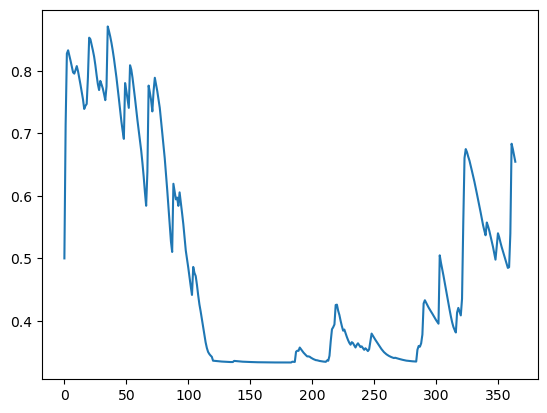

In [83]:
plt.plot(out[200,200,:])

In [8]:
%%time
nx = 95*2
ny = 40*2
nt = len(tas)

# Constant parameters
Ts = -1.           # Snowfall threshold
Tm = 1.            # Snowmelt threshold
s_c = 0.4          # Crop-specific threshold factor
r_I = 0.9          # Irrigation inefficiency factor
r_FI = 1           # Framer irrigation inefficiency factor (added by David to test some things, in WBM r_FI = 1)
r_p = 0.5          # Runoff-percolation partitioning factor
gamma_S = 0.5      # Soil moisture surplus coefficient
gamma_G = 0.0167   # Groundwater leakage coefficient
phi = lat          # Latitude

# Initial conditions
Wi_init = 0.5           # Canopy water storage
Sp_init = 5             # Snowpack
Wg_init = 100000.       # Groundwater

# Uncertain parameters
alpha = 5
awCap = 120
GS_start = 120
GS_length = 182
wilting_point = 0.5
beta_HBV = 2.

rootDepth_oGS = 600
rootDepth_GS_factor = 3

out_WsFrac = simulate_water_balance(
    Ws_frac_init = np.full((nx,ny),0.5),
    Wi_init = np.full((nx,ny),Wi_init),
    Sp_init = np.full((nx,ny),Sp_init),
    Wg_init = np.full((nx,ny),1000),
    P = np.tile(pr, (nx,ny,1)),
    T = np.tile(tas, (nx,ny,1)),
    Ts = Ts,
    Tm = Tm,
    rootDepth_oGS = np.full((nx,ny),rootDepth_oGS),
    rootDepth_GS_factor = np.full((nx,ny),rootDepth_GS_factor),
    rootDepth_all = np.full((nx,ny),np.nan),
    awCap = np.full((nx,ny),awCap),
    GS_start = np.full((nx,ny),GS_start),
    GS_length = np.full((nx,ny),GS_length),
    lai = np.tile(lai, (nx,ny,1)),
    Kc = np.ones((nx,ny,365)),
    alpha = np.full((nx,ny),alpha),
    s_c = s_c,
    r_I = r_I,
    r_FI = r_FI,
    r_p = r_p,
    beta_HBV = beta_HBV,
    gamma_S = gamma_S,
    gamma_G = gamma_G,
    phi = phi,
    wilting_point = np.full((nx,ny), wilting_point),
)

CPU times: user 2min 41s, sys: 4.26 s, total: 2min 45s
Wall time: 2min 46s


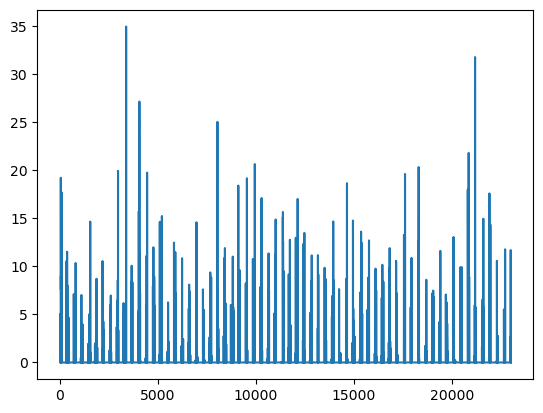

In [274]:
k = 9000
n = 10000
# plt.plot(out_Sp[2,1,:])
plt.plot(out_Ms)

## pre-calibration (pointwise)

### Location 1

In [5]:
lai = np.array([0.37301 , 0.372121, 0.371232, 0.370343, 0.369454, 0.368565,
       0.367676, 0.366786, 0.365897, 0.365008, 0.364119, 0.36323 ,
       0.362341, 0.361451, 0.360562, 0.359854, 0.360239, 0.360809,
       0.361379, 0.361948, 0.362518, 0.363088, 0.363658, 0.364227,
       0.364797, 0.365367, 0.365936, 0.366506, 0.367076, 0.367646,
       0.368216, 0.368785, 0.369355, 0.369925, 0.370495, 0.371064,
       0.371634, 0.372204, 0.372774, 0.373343, 0.373913, 0.374483,
       0.375053, 0.375623, 0.376192, 0.376771, 0.37736 , 0.377949,
       0.378537, 0.379126, 0.379715, 0.380303, 0.380892, 0.381481,
       0.38207 , 0.382658, 0.383247, 0.383836, 0.384424, 0.385013,
       0.385602, 0.38619 , 0.386779, 0.387368, 0.387957, 0.388545,
       0.389134, 0.389723, 0.390311, 0.3909  , 0.391489, 0.392077,
       0.392666, 0.393255, 0.394183, 0.397169, 0.400502, 0.403836,
       0.407169, 0.410502, 0.413835, 0.417168, 0.420501, 0.423834,
       0.427167, 0.4305  , 0.433833, 0.437166, 0.4405  , 0.443833,
       0.447166, 0.450499, 0.453832, 0.457165, 0.460498, 0.463831,
       0.467164, 0.470497, 0.473831, 0.477164, 0.480497, 0.48383 ,
       0.487163, 0.490496, 0.493829, 0.501162, 0.512537, 0.523912,
       0.535286, 0.546661, 0.558036, 0.56941 , 0.580785, 0.59216 ,
       0.603535, 0.61491 , 0.626284, 0.637659, 0.649034, 0.660408,
       0.671783, 0.683158, 0.694532, 0.705907, 0.717282, 0.728657,
       0.740032, 0.751406, 0.762781, 0.774155, 0.78553 , 0.796905,
       0.80828 , 0.819655, 0.831029, 0.844639, 0.871794, 0.901232,
       0.930668, 0.960106, 0.989543, 1.01898 , 1.048418, 1.077855,
       1.107292, 1.136729, 1.166167, 1.195603, 1.225041, 1.254478,
       1.283916, 1.313352, 1.342789, 1.372227, 1.401664, 1.431102,
       1.460538, 1.489975, 1.519413, 1.548851, 1.578288, 1.607724,
       1.637161, 1.666599, 1.696037, 1.725474, 1.778527, 1.855446,
       1.932363, 2.00928 , 2.086198, 2.163116, 2.240034, 2.316951,
       2.393868, 2.470787, 2.547706, 2.624621, 2.701539, 2.778458,
       2.855376, 2.932295, 3.00921 , 3.086128, 3.163047, 3.239965,
       3.316881, 3.393799, 3.470718, 3.547636, 3.624552, 3.701471,
       3.778388, 3.855307, 3.932222, 4.00914 , 4.078506, 4.102067,
       4.117915, 4.133764, 4.149613, 4.165462, 4.181311, 4.197159,
       4.213008, 4.228857, 4.244706, 4.260554, 4.276402, 4.292252,
       4.308101, 4.323949, 4.339798, 4.355647, 4.371495, 4.387344,
       4.403193, 4.419041, 4.43489 , 4.450739, 4.466588, 4.482437,
       4.498286, 4.514134, 4.529983, 4.545832, 4.56168 , 4.568269,
       4.518737, 4.459748, 4.400761, 4.341772, 4.282786, 4.223799,
       4.164811, 4.105821, 4.046835, 3.987848, 3.928862, 3.869873,
       3.810884, 3.751898, 3.69291 , 3.633921, 3.574935, 3.515946,
       3.456961, 3.397972, 3.338983, 3.279997, 3.221009, 3.16202 ,
       3.103035, 3.044045, 2.98506 , 2.926071, 2.867083, 2.808097,
       2.751944, 2.698654, 2.645368, 2.592079, 2.53879 , 2.485503,
       2.432214, 2.378927, 2.325638, 2.272349, 2.219062, 2.165772,
       2.112485, 2.059197, 2.005908, 1.952621, 1.899333, 1.846045,
       1.792756, 1.739468, 1.68618 , 1.632892, 1.579604, 1.526315,
       1.473027, 1.419739, 1.366451, 1.313163, 1.259875, 1.206586,
       1.157592, 1.134627, 1.116047, 1.097465, 1.078884, 1.060303,
       1.041721, 1.02314 , 1.00456 , 0.985979, 0.967397, 0.948817,
       0.930235, 0.911655, 0.893074, 0.874493, 0.855911, 0.83733 ,
       0.818749, 0.800169, 0.781587, 0.763006, 0.744425, 0.725844,
       0.707263, 0.688682, 0.670101, 0.65152 , 0.632939, 0.614358,
       0.595777, 0.583189, 0.576658, 0.570127, 0.563595, 0.557064,
       0.550533, 0.544002, 0.53747 , 0.530939, 0.524408, 0.517877,
       0.511345, 0.504814, 0.498283, 0.491752, 0.48522 , 0.478689,
       0.472158, 0.465627, 0.459095, 0.452564, 0.446033, 0.439502,
       0.43297 , 0.426439, 0.419908, 0.413377, 0.406845, 0.400314,
       0.393783, 0.387949, 0.386348, 0.385458, 0.384569, 0.38368 ,
       0.382791, 0.381902, 0.381013, 0.380123, 0.379234, 0.378345,
       0.377456, 0.376567, 0.375678, 0.374789, 0.373899])

In [6]:
lat, lon = 40, -90

# Read
df_livneh_vic = pd.read_csv('../data/WBM_calibration/lat40.00n_lon90.00w.csv')

# Get climate drivers
tas = df_livneh_vic['tas'].to_numpy()
pr = df_livneh_vic['pr'].to_numpy()
soilMoistFrac = df_livneh_vic['soilMoistFrac'].to_numpy()

In [141]:
#################
# Calibration
#################

In [243]:
# Constant parameters
Ts = -1.           # Snowfall threshold
Tm = 1.            # Snowmelt threshold
s_c = 0.4          # Crop-specific threshold factor
r_I = 0.9          # Irrigation inefficiency factor
r_FI = 1           # Framer irrigation inefficiency factor (added by David to test some things, in WBM r_FI = 1)
r_p = 0.5          # Runoff-percolation partitioning factor
gamma_S = 0.5      # Soil moisture surplus coefficient
gamma_G = 0.0167   # Groundwater leakage coefficient
phi = lat          # Latitude

# Initial conditions
Wi_init = 0.5           # Canopy water storage
Sp_init = 0             # Snowpack
Wg_init = 100000.       # Groundwater

# Uncertain parameters
alpha = 5
awCap = 120
GS_start = 120
GS_lenght = 182
wilting_point = 0.5
beta_HBV = 2.

rootDepth_oGS = 600
rootDepth_GS_factor = 3

In [244]:
Ws_frac_tmp, Ws_tmp, Wcap_tmp, Ms_tmp, Sp_tmp = simulate_water_balance(
        Ws_frac_init = 0.5,
        Wi_init = Wi_init,
        Sp_init = Sp_init,
        Wg_init = Wg_init,
        P = pr,
        T = tas,
        Ts = Ts,
        Tm = Tm,
        rootDepth_oGS = rootDepth_oGS,
        rootDepth_GS_factor = rootDepth_GS_factor,
        rootDepth_all = False,
        awCap = awCap,
        GS_start = GS_start,
        GS_length = GS_length,                                     
        lai = lai,
        Kc = [1 for _ in lai],
        alpha = alpha,
        s_c = s_c,
        r_I = r_I,
        r_FI = r_FI,
        r_p = r_p,
        beta_HBV = beta_HBV,
        gamma_S = gamma_S,
        gamma_G = gamma_G,
        phi=phi,
        wilting_point = wilting_point)

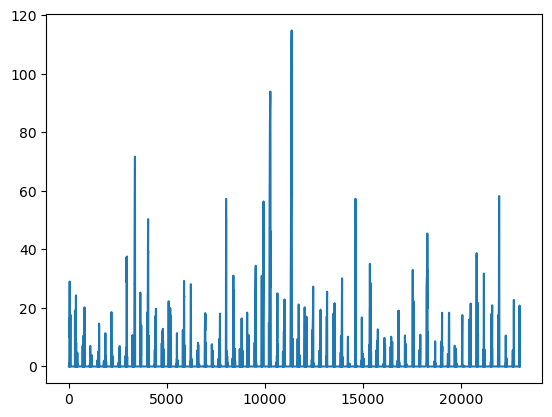

In [246]:
plt.plot(Sp_tmp)

In [88]:
# # Uncertain params
# n_sample = 5000
# alpha_sample = np.random.uniform(0.0001, 10, n_sample) # 5 central
# awCap_sample = np.random.uniform(12, 240, n_sample) # 120 central
# GS_start_sample = np.random.uniform(50, 200, n_sample) # 104 central
# GS_length_sample = np.random.uniform(100, 200, n_sample) # 182 central
# wilting_point_sample = np.random.uniform(0.00, 1., n_sample) # ? central
# beta_HBV_sample = np.random.uniform(1., 6., n_sample) # ? central

# rootDepth_oGS_sample = np.random.uniform(100, 1200, n_sample) # 600 central
# rootDepth_GS_factor_sample = np.random.uniform(2., 10., n_sample) # 1600 central
# rootDepth_GS_sample = np.random.uniform(300, 5000, n_sample) # 1600 central
# rootDepth_all_sample = np.random.uniform(100, 2500, n_sample) # ? central

In [89]:
# i = 1000
# Ws_frac_tmp = simulate_water_balance(
#         Ws_frac_init = 0.5,
#         Wi_init = Wi_init,
#         Sp_init = Sp_init,
#         Wg_init = Wg_init,
#         P = pr,
#         T = tas,
#         Ts = Ts,
#         Tm = Tm,
#         rootDepth_oGS = rootDepth_oGS_sample[i],
#         rootDepth_GS_factor = rootDepth_GS_factor_sample[i],
#         rootDepth_all = rootDepth_all_sample[i],
#         awCap = awCap_sample[i],
#         GS_start = GS_start_sample[i],
#         GS_length = GS_length_sample[i],                                     
#         lai = lai,
#         Kc = [1 for _ in lai],
#         alpha = alpha_sample[i],
#         s_c = s_c,
#         r_I = r_I,
#         r_FI = r_FI,
#         r_p = r_p,
#         beta_HBV = beta_HBV_sample[i],
#         gamma_S = gamma_S,
#         gamma_G = gamma_G,
#         phi=phi,
#         wilting_point = wilting_point_sample[i])

In [19]:
%%time
# No spinup
delayed = []

for i in range(n_sample):
    Ws_frac_tmp = dask.delayed(simulate_water_balance)(
        Ws_frac_init = 0.5,
        Wi_init = Wi_init,
        Sp_init = Sp_init,
        Wg_init = Wg_init,
        P = pr,
        T = tas,
        Ts = Ts,
        Tm = Tm,
        rootDepth_oGS = rootDepth_oGS_sample[i],
        rootDepth_GS_factor = rootDepth_GS_factor_sample[i],
        rootDepth_all = rootDepth_all_sample[i],
        awCap = awCap_sample[i],
        GS_start = GS_start_sample[i],
        GS_length = GS_length_sample[i],                                     
        lai = lai,
        Kc = [1 for _ in lai],
        alpha = alpha_sample[i],
        s_c = s_c,
        r_I = r_I,
        r_FI = r_FI,
        r_p = r_p,
        beta_HBV = beta_HBV_sample[i],
        gamma_S = gamma_S,
        gamma_G = gamma_G,
        phi=phi,
        wilting_point = wilting_point_sample[i])
    
    delayed.append(Ws_frac_tmp)
    
# Compute
Ws_frac_sample_loc1 = dask.compute(*delayed)

CPU times: user 27 s, sys: 2.07 s, total: 29.1 s
Wall time: 2min 52s


In [21]:
# Best parameters

# Get MSEs
mse_sample = []
for i in range(n_sample):
    mse = np.mean((np.array(Ws_frac_sample_loc1[i]) - soilMoistFrac) ** 2)
    mse_sample.append(mse)

# Best single set
i_best = np.argmin(np.array(mse_sample))
print(i_best)

# Top N parameter combos
n_cutoff = 100
i_top = np.argpartition(mse_sample, n_cutoff)[:n_cutoff]

3969


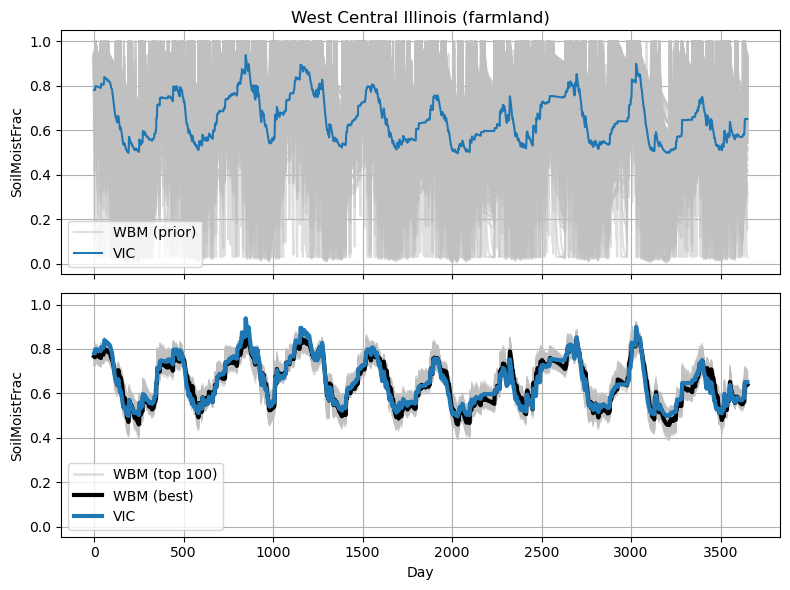

In [28]:
# Plot
fig, axs = plt.subplots(2,1, figsize=(8,6), sharex=True, sharey=True)

start = 365*20
end = 365*30

# Prior
ax = axs[0]
for i in range(1, n_sample, 10):
    ax.plot(Ws_frac_sample_loc1[i][start:end], color='silver', alpha=0.5, label=None)

ax.plot(Ws_frac_sample_loc1[0][start:end], color='silver', alpha=0.5, label='WBM (prior)')
ax.plot(soilMoistFrac[start:end], label='VIC')
ax.grid()
ax.legend()
ax.set_ylabel('SoilMoistFrac')
ax.set_title('West Central Illinois (farmland)')

# Posterior
ax=axs[1]

for i in i_top[1:]:
    ax.plot(Ws_frac_sample_loc1[i][start:end], color='silver', lw=1, alpha=0.5, label=None)

ax.plot(Ws_frac_sample_loc1[i][start:end], color='silver', lw=2, alpha=0.5, label='WBM (top 100)')
ax.plot(Ws_frac_sample_loc1[i_best][start:end], color='black', label='WBM (best)', lw=3)
ax.plot(soilMoistFrac[start:end], label='VIC', lw=3)
ax.legend()

ax.set_xlabel('Day')
ax.set_ylabel('SoilMoistFrac')
ax.grid()
ax.legend()

plt.tight_layout()
# plt.savefig('../figs/WBM_precal_test.png')
plt.show()

In [23]:
# best params
print(f"Best alpha: {str(alpha_sample[i_best])}")
print(f"Best rootDepth_oGS: {str(rootDepth_oGS_sample[i_best])}")
print(f"Best rootDepth_factor: {str(rootDepth_GS_factor_sample[i_best])}")
print(f"Best awCap: {str(awCap_sample[i_best])}")
print(f"Best GS_start: {str(GS_start_sample[i_best])}")
print(f"Best GS_length: {str(GS_length_sample[i_best])}")
print(f"Best wilting_point: {str(wilting_point_sample[i_best])}")
print(f"Best HBV recharge parameter: {str(beta_HBV_sample[i_best])}")

Best alpha: 7.720169762396321
Best rootDepth_oGS: 255.15848613204844
Best rootDepth_factor: 2.3656169390022868
Best awCap: 133.80647044887382
Best GS_start: 114.35974632883621
Best GS_length: 194.159065119851
Best wilting_point: 0.8041417785596435
Best HBV recharge parameter: 1.5534296945889383


### Location 2

In [5]:
lai = np.array([0.37301 , 0.372121, 0.371232, 0.370343, 0.369454, 0.368565,
       0.367676, 0.366786, 0.365897, 0.365008, 0.364119, 0.36323 ,
       0.362341, 0.361451, 0.360562, 0.359854, 0.360239, 0.360809,
       0.361379, 0.361948, 0.362518, 0.363088, 0.363658, 0.364227,
       0.364797, 0.365367, 0.365936, 0.366506, 0.367076, 0.367646,
       0.368216, 0.368785, 0.369355, 0.369925, 0.370495, 0.371064,
       0.371634, 0.372204, 0.372774, 0.373343, 0.373913, 0.374483,
       0.375053, 0.375623, 0.376192, 0.376771, 0.37736 , 0.377949,
       0.378537, 0.379126, 0.379715, 0.380303, 0.380892, 0.381481,
       0.38207 , 0.382658, 0.383247, 0.383836, 0.384424, 0.385013,
       0.385602, 0.38619 , 0.386779, 0.387368, 0.387957, 0.388545,
       0.389134, 0.389723, 0.390311, 0.3909  , 0.391489, 0.392077,
       0.392666, 0.393255, 0.394183, 0.397169, 0.400502, 0.403836,
       0.407169, 0.410502, 0.413835, 0.417168, 0.420501, 0.423834,
       0.427167, 0.4305  , 0.433833, 0.437166, 0.4405  , 0.443833,
       0.447166, 0.450499, 0.453832, 0.457165, 0.460498, 0.463831,
       0.467164, 0.470497, 0.473831, 0.477164, 0.480497, 0.48383 ,
       0.487163, 0.490496, 0.493829, 0.501162, 0.512537, 0.523912,
       0.535286, 0.546661, 0.558036, 0.56941 , 0.580785, 0.59216 ,
       0.603535, 0.61491 , 0.626284, 0.637659, 0.649034, 0.660408,
       0.671783, 0.683158, 0.694532, 0.705907, 0.717282, 0.728657,
       0.740032, 0.751406, 0.762781, 0.774155, 0.78553 , 0.796905,
       0.80828 , 0.819655, 0.831029, 0.844639, 0.871794, 0.901232,
       0.930668, 0.960106, 0.989543, 1.01898 , 1.048418, 1.077855,
       1.107292, 1.136729, 1.166167, 1.195603, 1.225041, 1.254478,
       1.283916, 1.313352, 1.342789, 1.372227, 1.401664, 1.431102,
       1.460538, 1.489975, 1.519413, 1.548851, 1.578288, 1.607724,
       1.637161, 1.666599, 1.696037, 1.725474, 1.778527, 1.855446,
       1.932363, 2.00928 , 2.086198, 2.163116, 2.240034, 2.316951,
       2.393868, 2.470787, 2.547706, 2.624621, 2.701539, 2.778458,
       2.855376, 2.932295, 3.00921 , 3.086128, 3.163047, 3.239965,
       3.316881, 3.393799, 3.470718, 3.547636, 3.624552, 3.701471,
       3.778388, 3.855307, 3.932222, 4.00914 , 4.078506, 4.102067,
       4.117915, 4.133764, 4.149613, 4.165462, 4.181311, 4.197159,
       4.213008, 4.228857, 4.244706, 4.260554, 4.276402, 4.292252,
       4.308101, 4.323949, 4.339798, 4.355647, 4.371495, 4.387344,
       4.403193, 4.419041, 4.43489 , 4.450739, 4.466588, 4.482437,
       4.498286, 4.514134, 4.529983, 4.545832, 4.56168 , 4.568269,
       4.518737, 4.459748, 4.400761, 4.341772, 4.282786, 4.223799,
       4.164811, 4.105821, 4.046835, 3.987848, 3.928862, 3.869873,
       3.810884, 3.751898, 3.69291 , 3.633921, 3.574935, 3.515946,
       3.456961, 3.397972, 3.338983, 3.279997, 3.221009, 3.16202 ,
       3.103035, 3.044045, 2.98506 , 2.926071, 2.867083, 2.808097,
       2.751944, 2.698654, 2.645368, 2.592079, 2.53879 , 2.485503,
       2.432214, 2.378927, 2.325638, 2.272349, 2.219062, 2.165772,
       2.112485, 2.059197, 2.005908, 1.952621, 1.899333, 1.846045,
       1.792756, 1.739468, 1.68618 , 1.632892, 1.579604, 1.526315,
       1.473027, 1.419739, 1.366451, 1.313163, 1.259875, 1.206586,
       1.157592, 1.134627, 1.116047, 1.097465, 1.078884, 1.060303,
       1.041721, 1.02314 , 1.00456 , 0.985979, 0.967397, 0.948817,
       0.930235, 0.911655, 0.893074, 0.874493, 0.855911, 0.83733 ,
       0.818749, 0.800169, 0.781587, 0.763006, 0.744425, 0.725844,
       0.707263, 0.688682, 0.670101, 0.65152 , 0.632939, 0.614358,
       0.595777, 0.583189, 0.576658, 0.570127, 0.563595, 0.557064,
       0.550533, 0.544002, 0.53747 , 0.530939, 0.524408, 0.517877,
       0.511345, 0.504814, 0.498283, 0.491752, 0.48522 , 0.478689,
       0.472158, 0.465627, 0.459095, 0.452564, 0.446033, 0.439502,
       0.43297 , 0.426439, 0.419908, 0.413377, 0.406845, 0.400314,
       0.393783, 0.387949, 0.386348, 0.385458, 0.384569, 0.38368 ,
       0.382791, 0.381902, 0.381013, 0.380123, 0.379234, 0.378345,
       0.377456, 0.376567, 0.375678, 0.374789, 0.373899])

In [6]:
lat, lon = 41.87, -87.77

# Read
df_livneh_vic = pd.read_csv('../data/WBM_calibration/lat41.87n_lon87.77w.csv')

# Get climate drivers
tas = df_livneh_vic['tas'].to_numpy()
pr = df_livneh_vic['pr'].to_numpy()
soilMoistFrac = df_livneh_vic['soilMoistFrac'].to_numpy()

In [7]:
#################
# Calibration
#################

In [8]:
# Constant parameters
Ts = -1.           # Snowfall threshold
Tm = 1.            # Snowmelt threshold
s_c = 0.4          # Crop-specific threshold factor
r_I = 0.9          # Irrigation inefficiency factor
r_FI = 1           # Framer irrigation inefficiency factor (added by David to test some things, in WBM r_FI = 1)
r_p = 0.5          # Runoff-percolation partitioning factor
gamma_S = 0.5      # Soil moisture surplus coefficient
gamma_G = 0.0167   # Groundwater leakage coefficient
phi = lat          # Latitude

# Initial conditions
Wi_init = 0.5           # Canopy water storage
Sp_init = 0             # Snowpack
Wg_init = 100000.       # Groundwater

In [9]:
# Uncertain params
n_sample = 5000
alpha_sample = np.random.uniform(0.0001, 10, n_sample) # 5 central
awCap_sample = np.random.uniform(12, 240, n_sample) # 120 central
GS_start_sample = np.random.uniform(50, 200, n_sample) # 104 central
GS_length_sample = np.random.uniform(100, 200, n_sample) # 182 central
wilting_point_sample = np.random.uniform(0.00, 1., n_sample) # ? central
beta_HBV_sample = np.random.uniform(1., 6., n_sample) # ? central

rootDepth_oGS_sample = np.random.uniform(100, 1200, n_sample) # 600 central
rootDepth_GS_factor_sample = np.random.uniform(2., 10., n_sample) # 1600 central
rootDepth_GS_sample = np.random.uniform(300, 5000, n_sample) # 1600 central
rootDepth_all_sample = np.random.uniform(100, 2500, n_sample) # ? central

In [10]:
%%time
# No spinup
delayed = []

start = 0
end = -1

for i in range(n_sample):
    Ws_frac_tmp = dask.delayed(simulate_water_balance)(
        Ws_frac_init = 0.5,
        Wi_init = Wi_init,
        Sp_init = Sp_init,
        Wg_init = Wg_init,
        P = pr[start:end], 
        T = tas[start:end], 
        Ts = Ts,
        Tm = Tm,
        rootDepth_oGS = False, #rootDepth_oGS_sample[i],
        rootDepth_GS_factor = False, #rootDepth_GS_factor_sample[i],
        rootDepth_all = rootDepth_all_sample[i],
        awCap = awCap_sample[i],
        GS_start = GS_start_sample[i],
        GS_length = GS_length_sample[i],                                     
        lai = lai,
        Kc = [1 for _ in lai],
        alpha = alpha_sample[i],
        s_c = s_c,
        r_I = r_I,
        r_FI = r_FI,
        r_p = r_p,
        beta_HBV = beta_HBV_sample[i],
        gamma_S = gamma_S,
        gamma_G = gamma_G,
        phi=phi,
        wilting_point = wilting_point_sample[i])
    
    delayed.append(Ws_frac_tmp)
    
# Compute
Ws_frac_sample_loc2 = dask.compute(*delayed)

/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-11-01/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 1.72 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 27.7 s, sys: 4.42 s, total: 32.1 s
Wall time: 2min 54s


In [11]:
# Best parameters
start = 0
end = -1

# Get MSEs
mse_sample = []
for i in range(n_sample):
    mse = np.mean((np.array(Ws_frac_sample_loc2[i][start:end]) - soilMoistFrac[start:end-1]) ** 2)
    mse_sample.append(mse)

# Best single set
i_best = np.argmin(np.array(mse_sample))
print(i_best)

# Top N parameter combos
n_cutoff = 100
i_top = np.argpartition(mse_sample, n_cutoff)[:n_cutoff]

1433


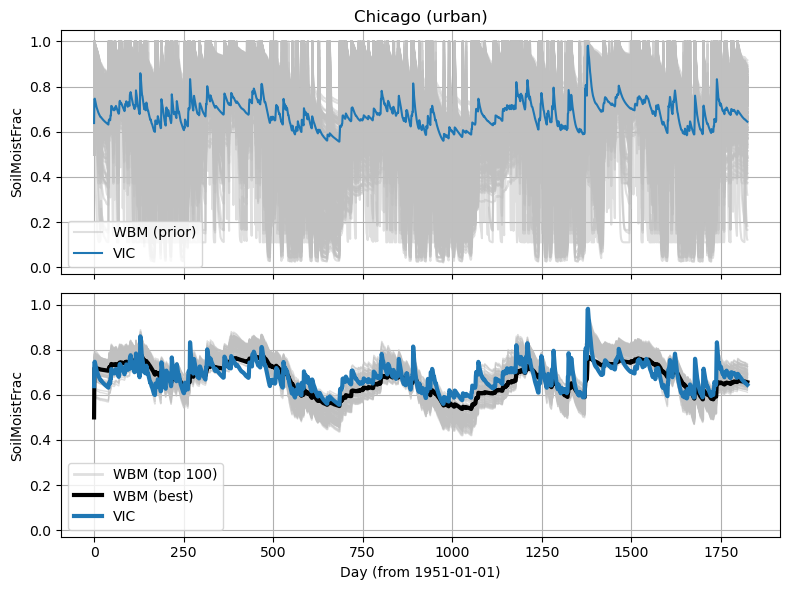

In [12]:
# Plot
fig, axs = plt.subplots(2,1, figsize=(8,6), sharex=True, sharey=True)

start = 0
end = 365*5

# Prior
ax = axs[0]
for i in range(1, n_sample, 10):
    ax.plot(Ws_frac_sample_loc2[i][start:end], color='silver', alpha=0.5, label=None)

ax.plot(Ws_frac_sample_loc2[0][start:end], color='silver', alpha=0.5, label='WBM (prior)')
ax.plot(soilMoistFrac[start:end], label='VIC')
ax.grid()
ax.legend()
ax.set_ylabel('SoilMoistFrac')
ax.set_title('Chicago (urban)')

# Posterior
ax=axs[1]

for i in i_top[1:]:
    ax.plot(Ws_frac_sample_loc2[i][start:end], color='silver', lw=1, alpha=0.5, label=None)

ax.plot(Ws_frac_sample_loc2[i][start:end], color='silver', lw=2, alpha=0.5, label='WBM (top 100)')
ax.plot(Ws_frac_sample_loc2[i_best][start:end], color='black', label='WBM (best)', lw=3)
ax.plot(soilMoistFrac[start:end], label='VIC', lw=3)
ax.legend()

ax.set_xlabel('Day (from 1951-01-01)')
ax.set_ylabel('SoilMoistFrac')
ax.grid()
ax.legend()

plt.tight_layout()
# plt.savefig('../figs/WBM_precal_test.png')
plt.show()

In [13]:
# best params
print(f"Best alpha: {str(alpha_sample[i_best])}")
print(f"Best rootDepth_all: {str(rootDepth_oGS_sample[i_best])}")
print(f"Best awCap: {str(awCap_sample[i_best])}")
print(f"Best wilting_point: {str(wilting_point_sample[i_best])}")
print(f"Best HBV recharge parameter: {str(beta_HBV_sample[i_best])}")

Best alpha: 1.6367649879144062
Best rootDepth_all: 541.9850484974654
Best awCap: 220.20702753767063
Best wilting_point: 0.6729194101203984
Best HBV recharge parameter: 1.092346204174314
